# Table of Contents
* [1. compositon](#1.-compositon)
	* [1.1 characters](#1.1-characters)
	* [1.2 objects](#1.2-objects)
	* [1.3 descriptions](#1.3-descriptions)
* [2. avg appearance](#2.-avg-appearance)
* [3. common entities](#3.-common-entities)
	* [3.1 characters](#3.1-characters)
	* [3.2 objects](#3.2-objects)
* [4. common verbs](#4.-common-verbs)
* [5. corpus level](#5.-corpus-level)
* [6. trajectories](#6.-trajectories)
* [7. next viz](#7.-next-viz)


In [8]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import functools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm as tqdm

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

from anigen_tools.dataset import FlintstonesDataset
from anigen_tools.mturk import unpickle_this, pickle_this
from anigen_tools.trajectory_viz import filter_chars, filter_description
from anigen_tools.trajectory_viz import avg_video_appearance
from anigen_tools.trajectory_viz import draw_trajectory_set
from anigen_tools.trajectory_viz import vid_filter

In [3]:
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.linewidth'] = 1

plt.rc('font',**{'family':'serif','serif':['Times']})
# plt.rc('font', family='serif')
# plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

plt.rc('text', usetex=True)

In [4]:
dataset = unpickle_this('../build_dataset/pickled_data/dataset_full26k.pkl')

In [5]:
def get_vid(video_id, dataset=dataset):
    return [vid for vid in dataset if vid.gid() == video_id][0]

def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
    if save:
        plt.savefig(outfile, bbox_inches='tight')

# 1. compositon

## 1.1 characters

In [8]:
vid_count = len(dataset)

In [9]:
char_counts = pd.Series([len(vid.data()['characters']) for vid in dataset])
count_dist = char_counts.value_counts()
norm_count_dist = count_dist / count_dist.sum()

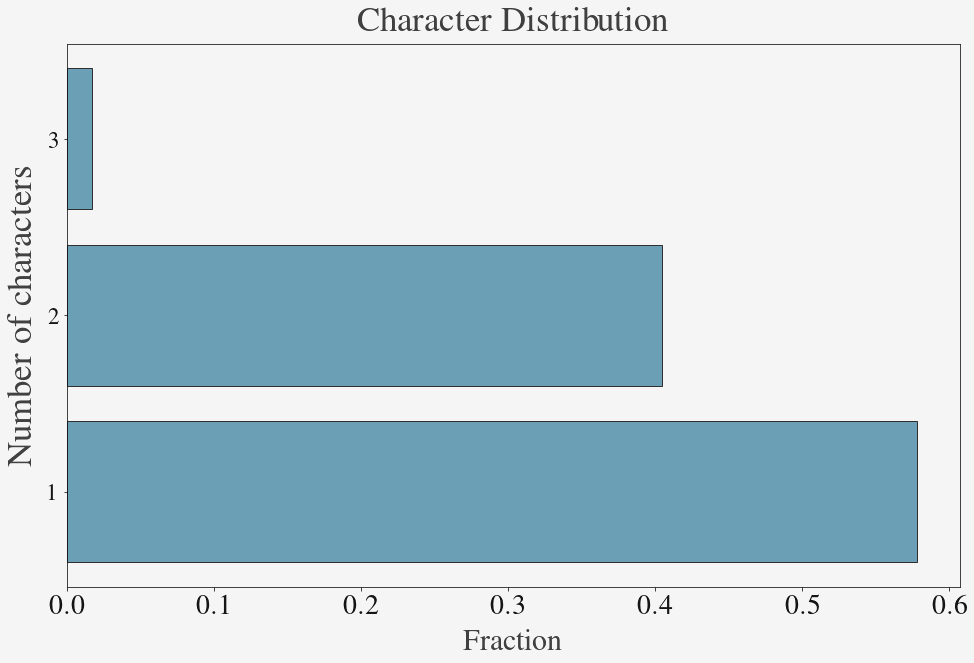

In [10]:
fig_labels = {
    'fig_title': 'Character Distribution', 
    'x_label': 'Fraction',
    'y_label': 'Number of characters'
}

fig = plt.barh(norm_count_dist.index, norm_count_dist.values)
_ = make_standard_fig(fig, fig_labels, save=False)
_ = plt.yticks(np.arange(1, 4, 1))

## 1.2 objects

In [11]:
obj_counts = pd.Series([len(vid.data()['objects']) for vid in dataset])
o_count_dist = obj_counts.value_counts()
norm_o_count_dist = o_count_dist / o_count_dist.sum()

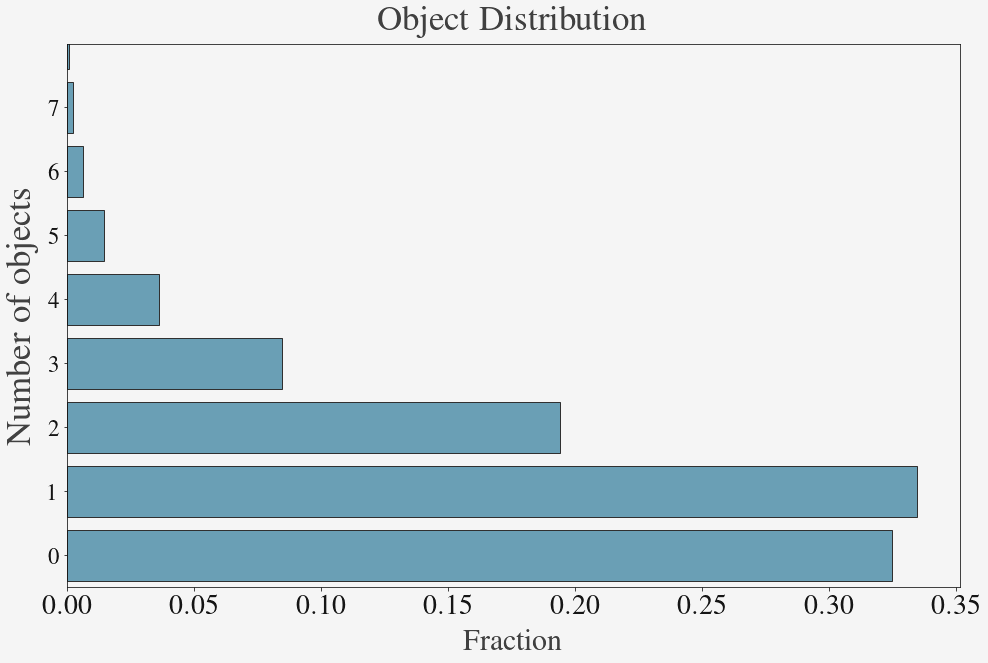

In [12]:
fig_labels = {
    'fig_title': 'Object Distribution', 
    'x_label': 'Fraction',
    'y_label': 'Number of objects'
}

fig = plt.barh(norm_o_count_dist.index, norm_o_count_dist.values)
_ = make_standard_fig(fig, fig_labels, save=True)
_ = plt.yticks(np.arange(0, 8, 1))
_ = plt.ylim(-0.5, 8)

## 1.3 descriptions

In [13]:
desc_lens = pd.Series([len(vid.description().split()) for vid in dataset])

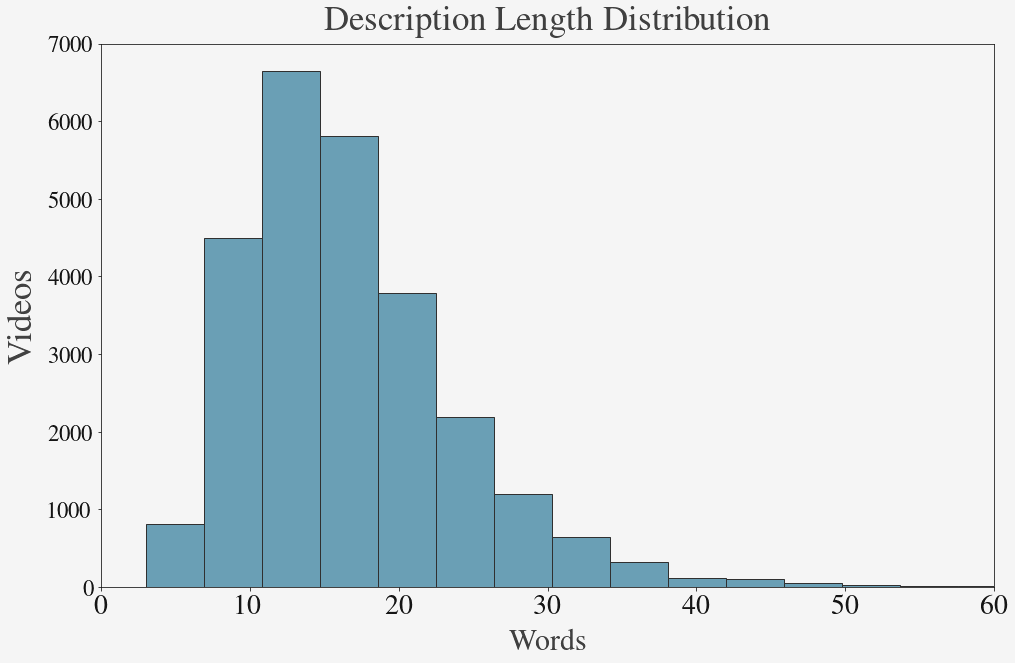

In [14]:
fig_labels = {
    'fig_title': 'Description Length Distribution', 
    'x_label': '# Words',
    'y_label': '# Videos'
}

fig = desc_lens.hist(bins=20)
_ = make_standard_fig(fig, fig_labels, save=False)
# _ = plt.yticks(np.arange(0, 8, 1))
_ = plt.xlim(0, 60)
_ = plt.ylim(0, 7000)

# 2. avg appearance

In [484]:
# filters_to_apply = [functools.partial(filter_chars, n_chars=1, chars_required=['fred']), functools.partial(filter_description, contains=['phone', 'picks up'])]
# vid_list = [vid for vid in dataset if vid_filter(vid, filters_to_apply)]

In [466]:
# avg_video_appearence(vid_list, 1)

# 3. common entities

## 3.1 characters

In [278]:
all_chars = [char for vid in dataset for char in vid.data()['characters']]
all_char_labels = pd.Series([char.data()['entityLabel'] for char in all_chars])
all_char_labels.value_counts()[:30]

fred                   13661
barney                  7386
wilma                   5853
betty                   3194
dino                     667
pebbles                  557
mr slate                 534
bamm bamm                 76
construction worker       65
hoppy                     53
baby puss                 49
Fred                      43
police officer            42
man                       42
circus performer          31
old man                   29
doctor                    24
man with blue dress       24
policeman                 21
the great gazoo           20
police man                19
bird                      19
Barney                    19
man in blue shirt         17
man with glasses          16
Mr. Slate                 16
nurse                     15
man with bow tie          14
man with blue shirt       14
woman                     13
dtype: int64

## 3.2 objects

In [308]:
all_objects = [char for vid in dataset for char in vid.data()['objects']]
all_obj_labels = pd.Series([char.data()['entityLabel'] for char in all_objects])
all_obj_labels.value_counts()[50:100]

clothes         109
tree            103
tv              102
plate            98
shoulders        96
stick            95
helmet           94
house            91
nose             91
seat             89
bow tie          87
hammock          85
object           85
cup              82
chest            82
feet             81
beard            81
chairs           79
bowling ball     79
box              79
mask             77
money            76
sunglasses       75
apron            75
horns            74
legs             74
bone             74
water            74
club             73
bench            72
scarf            72
foot             71
counter          70
dinosaur         66
sofa             66
microphone       64
piano            64
hammer           64
costume          61
tail             60
mirror           60
picture          60
fingers          59
fist             59
suit             58
uniform          57
rope             57
towel            56
sign             53
knife            52


In [ ]:
cv2.grabCut()

# 4. common verbs

# 5. corpus level

In [126]:
import nltk
import spacy
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [167]:
from nltk import BigramCollocationFinder

In [128]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [151]:
cached_sw = set(stopwords.words('english'))
cached_sw.update(list(string.punctuation))

In [155]:
main_characters_lower = {
            "fred",
            "wilma",
            "mr slate",
            "barney",
            "betty",
            "pebbles",
            "dino",
            "baby puss",
            "hoppy",
            "bamm bamm",
        }

In [127]:
vid_descriptions_raw = [vid.description() for vid in dataset]

In [136]:
description_corpus = ' '.join(vid_descriptions_raw)

In [139]:
tokenized_corpus = word_tokenize(description_corpus)

In [164]:
normalized_tokens = []
for toke in tokenized_corpus:
    clean_toke = toke.strip().lower()
    if clean_toke not in cached_sw and clean_toke not in main_characters_lower:
        normalized_tokens.append(clean_toke)

In [165]:
dc_freq_d = nltk.FreqDist(normalized_tokens)
most_common_words = dc_freq_d.most_common(20)

In [166]:
most_common_words

[('room', 13257),
 ('talking', 8965),
 ('standing', 6382),
 ('living', 4274),
 ('sitting', 3487),
 ('man', 3459),
 ('someone', 2934),
 ('outside', 2864),
 ('holding', 2620),
 ('speaking', 2475),
 ('car', 1915),
 ('talks', 1821),
 ('speaks', 1715),
 ('wearing', 1704),
 ('blue', 1698),
 ('head', 1673),
 ('looks', 1664),
 ('looking', 1578),
 ('something', 1570),
 ('doorway', 1527)]

In [168]:
phrase_bi_finder = BigramCollocationFinder.from_words(normalized_tokens)

In [169]:
phrase_bi_finder.apply_freq_filter(75) 

In [170]:
most_common_bigrams = []

for k,v in sorted(phrase_bi_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:15]:
    most_common_bigrams.append((' '.join(k), v))

In [171]:
most_common_bigrams

[('living room', 4266),
 ('room talking', 2399),
 ('standing room', 2090),
 ('talking someone', 1593),
 ('dining room', 756),
 ('mr slate', 706),
 ('room standing', 652),
 ('room speaking', 647),
 ('standing outside', 607),
 ('standing living', 602),
 ('talking room', 580),
 ('standing doorway', 575),
 ('room holding', 571),
 ('says something', 558),
 ('talking standing', 543)]

In [173]:
phrase_bi_finder.nbest(bigram_measures.pmi, 20)

[('construction', 'worker'),
 ('golf', 'course'),
 ('police', 'officer'),
 ('bowling', 'alley'),
 ('bow', 'tie'),
 ('bamm', 'bamm'),
 ('bowling', 'ball'),
 ('eyes', 'closed'),
 ('arms', 'crossed'),
 ('mr', 'slate'),
 ('closes', 'eyes'),
 ('watching', 'tv'),
 ('hands', 'hips'),
 ('reading', 'book'),
 ('says', 'something'),
 ('camera', 'left'),
 ('laying', 'bed'),
 ('bed', 'bedroom'),
 ('saying', 'something'),
 ('camera', 'right')]

In [274]:
phrase_bi_finder.score_ngram(bigram_measures.pmi, 'bed', 'bedroom')

6.437502853264231

In [271]:
import gensim

from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

In [240]:
vid_docs = [[w.lower().strip() for w in word_tokenize(vd) if w not in cached_sw] for vd in vid_descriptions_raw]

In [241]:
bigram = Phrases(vid_docs, scoring='npmi', threshold=-1)

In [242]:
bigram_phraser = Phraser(bigram)

In [254]:
bigram_phraser.score_item('', '', scorer='npmi', components=[b'barney', b'walks'])

(b'barney', b'walks')


0.0939014438087678

In [255]:
# bigram[['fred', 'walks', 'in']]

In [270]:
bigram_phraser.score_item('', '', scorer='npmi', components=[b'sitting', b''])

(b'sitting', b'car')


0.3520796607731733

# 6. trajectories

In [368]:
object_of_interest = 'couch'

In [369]:
filters_to_apply = [functools.partial(filter_description, contains=[object_of_interest])]
# filters_to_apply = [functools.partial(filter_chars, n_chars=1, chars_required=['wilma']), functools.partial(filter_description, contains=['walk'])]
vid_list = [vid for vid in dataset if vid_filter(vid, filters_to_apply)]
len(vid_list)

650

In [370]:
avg_image = avg_video_appearance(vid_list)

100%|██████████| 650/650 [00:15<00:00, 42.36it/s]


In [371]:
%%capture
test_draw = draw_trajectory_set(vid_list, object_of_interest, ent_type='objects', avg_img=avg_image, mag=0.5)
# test_draw = draw_trajectory_set(vid_list, 'hat', ent_type='objects', avg_img=avg_image, mag=0.5)
# test_draw = draw_trajectory_set(vid_list, 'wilma', ent_type='characters', avg_img=avg_image, mag=0.5)

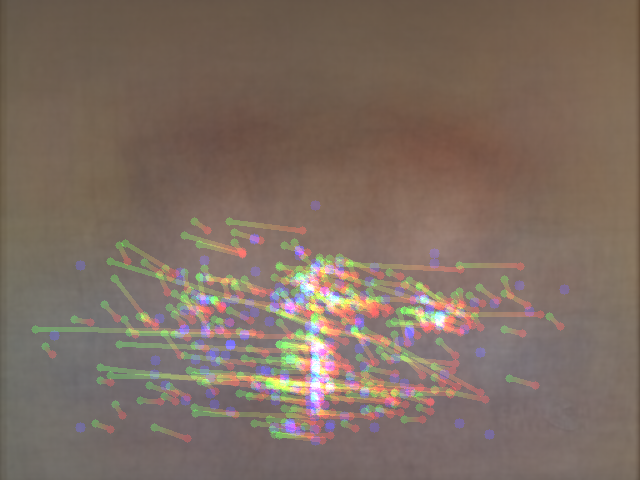

In [372]:
drawn_img = pil.fromarray(test_draw)
drawn_img

# 7. location heatmaps

In [900]:
data_dir = '/Users/schwenk/wrk/animation_gan/dataset/v2p0/trajectories'
tracking_dir = 'tracking'
segmentation_dir = 'segmentation'
frame_arr_dir = 'frame_arr_data'

o_size = (640, 480)

In [901]:
import seaborn as sns

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

In [902]:
def average_ent_segments(ent_list):
    store_res = np.zeros((128, 128))
    for ent in ent_list:
        ent_mask = np.load(os.path.join(data_dir, segmentation_dir, ent.gid() + '_segm.npy.npz'))['arr_0'].astype(np.uint64)
        ent_mean = ent_mask.mean(axis=0)
        store_res += ent_mean
    return store_res / len(ent_list)

In [914]:
def make_heatmap(segm_avg):
    my_cmap = sns.light_palette("Navy", as_cmap=True)
    
    ent_hm = sbn.heatmap(segm_avg, cmap='viridis', vmin=0, vmax=1, cbar=False)
    ent_hm.axis('off')
    figure = ent_hm.get_figure()    
    
    canvas = FigureCanvas(figure)
    ax = fig.gca()
    ax.text(0.0,0.0,"Test", fontsize=45)
    ax.axis('off')

    canvas.draw()  

    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3) 

    single_row = image[500, :, 0]
    img_start_x = np.argmin(single_row == 245)
    img_end_x = np.argmax(single_row[img_start_x:] == 245) + img_start_x
    single_col = image[:, 200, 0]
    img_start_y = np.argmin(single_col == 245)
    img_end_y = np.argmax(single_col[img_start_y:] == 245) + img_start_y
    
    heatmap_cropped = image[img_start_y: img_end_y , img_start_x: img_end_x]
    heatmap_img = pil.fromarray(heatmap_cropped).resize((640, 480))
    return heatmap_img

def overlay_heatmap(avg_img, heatmap_img):
    avg_img = avg_img.convert("RGBA")
    heatmap_img = heatmap_img.convert("RGBA")
    
    img_gray = np.array(heatmap_img.convert('L'))
    max_mag = img_gray.max()
    min_mag = img_gray.min()
    
    width, height = heatmap_img.size
    pixdata = heatmap.load()
    for y in range(height):
        for x in range(width):
            pixmag = img_gray[y, x]
            alpha_val = int(255 * (pixmag - min_mag) / (max_mag - min_mag))
            pixdata[x, y] = (*pixdata[x, y][:-1], alpha_val)
    r, g, b, a = heatmap_img.split()
    heatmap_img = pil.merge("RGB", (r, g, b))
    mask = pil.merge("L", (a,))
    avg_img.paste(heatmap_img, (0, 0), mask)
    return avg_img

In [920]:
test_ents = [obj for vid in dataset for obj in vid.data()['objects'] if 'couch' in obj.data()['entityLabel']]
# test_ents = [obj for vid in dataset for obj in vid.data()['objects'] if 'hammer' in obj.data()['entityLabel']]

avg_masks = average_ent_segments(tqdm(test_ents))

100%|██████████| 647/647 [00:05<00:00, 110.02it/s]


In [921]:
%%capture
avg_bg = pil.fromarray(avg_image)
heatmap = make_heatmap(avg_masks)

In [922]:
heatmap_viz = overlay_heatmap(avg_bg, heatmap)

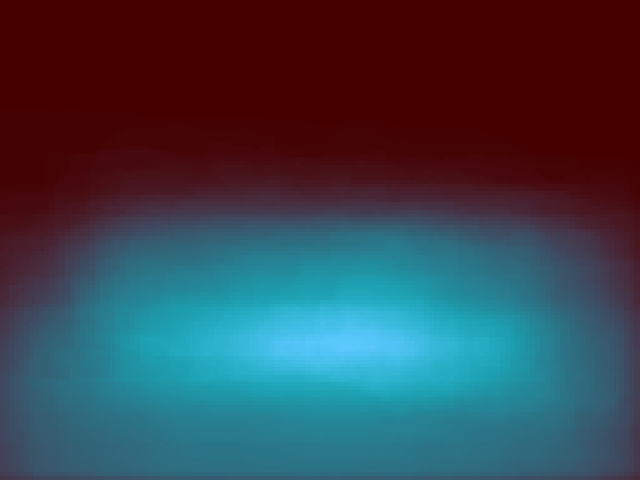

In [923]:
heatmap

In [918]:
np.array(heatmap_viz)

array([[[ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        ..., 
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255]],

       [[ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        ..., 
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255]],

       [[ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        ..., 
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255],
        [ 68,   1,   0, 255]],

       ..., 
       [[ 69,  55,  74, 255],
        [ 69,  55,  74, 255],
        [ 69,  55,  74, 255],
        ..., 
        [ 71,  44,  60, 255],
        [ 71,  44,  60, 255],
        [ 71,  44,  60, 255]],

       [[ 69,  55,  74, 255],
        [ 69,  55,  74, 255],
        [ 69,  55,  74, 255],
        ..., 
        [ 71,  44,  60, 255],
        [ 71,  44,  60, 255],
        [ 71,  44,  60, 255]],

       

# hide

In [ ]:
ent = test_ents[0]
ent_mask = np.load(os.path.join(data_dir, segmentation_dir, ent.gid() + '_segm.npy.npz'))['arr_0'].astype(np.uint64)
ent_mask2 = np.load(os.path.join(data_dir, segmentation_dir, test_ents[1].gid() + '_segm.npy.npz'))['arr_0'].astype(np.uint64)

In [292]:
ts = string.ascii_lowercase[:10]

In [293]:
def consecutive_groups(iterable):
    s = tuple(iterable)
    for size in range(1, len(s)+1):
        for index in range(len(s)+1-size):
            yield iterable[index:index+size]

In [296]:
# list(consecutive_groups(ts))

In [ ]:
get_entity()